<a href="https://colab.research.google.com/github/deepjyotikalita1994/glucose_prediction/blob/main/LSGRU_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import numpy

from numpy import array
from numpy import hstack
from numpy import insert

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [ ]:
from  google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/DK Dataset/Adult 8 (180 Days).csv')

In [ ]:
df

,Time,BG,CGM,CHO,insulin,LBGI,HBGI,Risk
0,09-08-2021 06:00,143.230000,144.607888,0.0,0.019025,0.000000,2.031487,2.031487
1,09-08-2021 06:05,143.230000,143.816545,0.0,0.019025,0.000000,2.031487,2.031487
2,09-08-2021 06:10,143.230000,146.652374,0.0,0.019025,0.000000,2.031487,2.031487
3,09-08-2021 06:15,143.230000,151.384258,0.0,0.019025,0.000000,2.031487,2.031487
4,09-08-2021 06:20,143.230000,156.535252,0.0,0.019025,0.000000,2.031487,2.031487
...,...,...,...,...,...,...,...,...
51835,10-08-2021 05:35,105.474757,92.379190,0.0,0.019025,0.144929,0.000000,0.144929
51836,10-08-2021 05:40,105.919054,90.825641,0.0,0.019025,0.126701,0.000000,0.126701
51837,10-08-2021 05:45,106.362621,93.390377,0.0,0.019025,0.109792,0.000000,0.109792
51838,10-08-2021 05:50,106.805322,97.786213,0.0,0.019025,0.094184,0.000000,0.094184


In [ ]:
df['Time']=pd.to_datetime(df['Time'], infer_datetime_format= True) 

In [ ]:
df_input=df[['CGM','CHO']]

In [ ]:
df_input

,CGM,CHO
0,144.607888,0.0
1,143.816545,0.0
2,146.652374,0.0
3,151.384258,0.0
4,156.535252,0.0
...,...,...
51835,92.379190,0.0
51836,90.825641,0.0
51837,93.390377,0.0
51838,97.786213,0.0


In [ ]:
m=df_input.iloc[:,0:1]
n=df_input.iloc[:,1:2]

**Scaling Using MinMax Scaler**

In [ ]:
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
data_scaled1 = scaler1.fit_transform(m)
data_scaled2 = scaler2.fit_transform(n)

In [ ]:
data_scaled = hstack((data_scaled1,data_scaled2))

In [ ]:
data_scaled

array([[0.39302608, 0.        ],
       [0.39008105, 0.        ],
       [0.40063476, 0.        ],
       ...,
       [0.20241705, 0.        ],
       [0.21877641, 0.        ],
       [0.23086415, 0.        ]])

In [ ]:
features=data_scaled
target=data_scaled[:,0]

In [ ]:
target

array([0.39302608, 0.39008105, 0.40063476, ..., 0.20241705, 0.21877641,
       0.23086415])

**Creating the Target for Calculation of 3 point prediction Ahead**

In [ ]:
a = insert(target, 0, 0)

In [ ]:
b=target[0:]
b1= numpy.roll(b,-1)
b2 = insert(b1, 0, 0)

In [ ]:
b=target[0:]
c1= numpy.roll(b,-2)
c2 = insert(c1, 0, 0)

In [ ]:
a5 = a.reshape((len(a), 1,1))
b5 = b2.reshape((len(b2), 1,1))
c5 = c2.reshape((len(c2), 1,1))

In [ ]:
target_data = hstack((a5, b5, c5))


In [ ]:
p=len(target_data)
new_target_data=target_data[:p-2]

In [ ]:
TimeseriesGenerator(features[:-1], new_target_data[:], length=2, sampling_rate=1, batch_size=1 )[0]

(array([[[0.39302608, 0.        ],
         [0.39008105, 0.        ]]]), array([[[0.39008105],
         [0.40063476],
         [0.41824475]]]))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features[:-1], new_target_data[:], test_size=0.20, random_state=123, shuffle= False)

In [ ]:
win_length=288
batch_size=32
num_features=2
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(128,input_shape= (win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=1))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.4))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.GRU(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(3))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 288, 128)          50688     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 288, 128)          0         
                                                                 
 lstm (LSTM)                 (None, 288, 128)          131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 288, 128)          0         
                                                                 
 dropout (Dropout)           (None, 288, 128)          0         
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [ ]:
model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(),metrics=[tf.metrics.MeanAbsoluteError()])

history=model.fit_generator(train_generator, epochs=50, validation_data=test_generator,shuffle=False)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


1287/1287 [==============================] - 62s 42ms/step - loss: 0.0032 - mean_absolute_error: 0.0398 - val_loss: 5.0512e-04 - val_mean_absolute_error: 0.0138
Epoch 2/50
1287/1287 [==============================] - 53s 41ms/step - loss: 0.0011 - mean_absolute_error: 0.0249 - val_loss: 3.3638e-04 - val_mean_absolute_error: 0.0111
Epoch 3/50
1287/1287 [==============================] - 53s 41ms/step - loss: 8.6776e-04 - mean_absolute_error: 0.0215 - val_loss: 3.2805e-04 - val_mean_absolute_error: 0.0099
Epoch 4/50
1287/1287 [==============================] - 53s 41ms/step - loss: 8.0065e-04 - mean_absolute_error: 0.0204 - val_loss: 2.9903e-04 - val_mean_absolute_error: 0.0098
Epoch 5/50
1287/1287 [==============================] - 53s 41ms/step - loss: 9.7210e-04 - mean_absolute_error: 0.0206 - val_loss: 3.9509e-04 - val_mean_absolute_error: 0.0132
Epoch 6/50
1287/1287 [==============================] - 53s 41ms/step - loss: 6.3469e-04 - mean_absolute_error: 0.0167 - val_loss: 3.1751e-

In [ ]:
model.evaluate_generator(test_generator,verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.0001911348954308778, 0.006091969553381205]

In [ ]:
predictions=model.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
predictions.shape[0]

10080

In [ ]:
predictions

array([[0.41120166, 0.3994045 , 0.3882119 ],
       [0.39249334, 0.37308738, 0.35806444],
       [0.33771062, 0.30433604, 0.28250238],
       ...,
       [0.19972661, 0.19814599, 0.2054702 ],
       [0.19530839, 0.20708427, 0.22360675],
       [0.205959  , 0.22468668, 0.24232483]], dtype=float32)

In [ ]:
y_test

array([[[0.30493081],
        [0.30653576],
        [0.36489058]],

       [[0.30653576],
        [0.36489058],
        [0.35468408]],

       [[0.36489058],
        [0.35468408],
        [0.36723862]],

       ...,

       [[0.19865385],
        [0.19287223],
        [0.20241705]],

       [[0.19287223],
        [0.20241705],
        [0.21877641]],

       [[0.20241705],
        [0.21877641],
        [0.23086415]]])

In [ ]:
x_test

array([[0.30653576, 0.        ],
       [0.36489058, 0.        ],
       [0.35468408, 0.        ],
       ...,
       [0.19287223, 0.        ],
       [0.20241705, 0.        ],
       [0.21877641, 0.        ]])

In [ ]:
x_test[:,1:][win_length:]

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [ ]:
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])],axis=1)

In [ ]:
df_pred

,0,1,2,0
0,0.411202,0.399404,0.388212,0.0
1,0.392493,0.373087,0.358064,0.0
2,0.337711,0.304336,0.282502,0.0
3,0.321367,0.322256,0.327976,0.0
4,0.333318,0.356369,0.375301,0.0
...,...,...,...,...
10075,0.229585,0.222053,0.217620,0.0
10076,0.214646,0.201850,0.196025,0.0
10077,0.199727,0.198146,0.205470,0.0
10078,0.195308,0.207084,0.223607,0.0


In [ ]:
rev_trans=scaler1.inverse_transform(df_pred)

In [ ]:
rev_trans

array([[149.4917473 , 146.32179701, 143.31429738,  39.        ],
       [144.4647374 , 139.25026778, 135.21353751,  39.        ],
       [129.74437284, 120.77647264, 114.90966979,  39.        ],
       ...,
       [ 92.66744506,  92.24272375,  94.2107745 ,  39.        ],
       [ 91.48024823,  94.64448081,  99.08414656,  39.        ],
       [ 94.34211803,  99.37432914, 104.11377909,  39.        ]])

In [ ]:
df_final=df_input[predictions.shape[0]*-1:]

In [ ]:
df_final['Predicted CGM']=rev_trans[:,0]
df_final['Predicted CGM2']=rev_trans[:,1]
df_final['Predicted CGM3']=rev_trans[:,2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
df_final

,CGM,CHO,Predicted CGM,Predicted CGM2,Predicted CGM3
41760,130.686555,0.0,149.491747,146.321797,143.314297
41761,127.107751,0.0,144.464737,139.250268,135.213538
41762,129.636901,0.0,129.744373,120.776473,114.909670
41763,135.378355,0.0,125.352671,125.591686,127.128569
41764,142.224317,0.0,128.564039,134.757969,139.845208
...,...,...,...,...,...
51835,92.379190,0.0,100.690559,98.666745,97.475396
51836,90.825641,0.0,96.676412,93.237956,91.672741
51837,93.390377,0.0,92.667445,92.242724,94.210775
51838,97.786213,0.0,91.480248,94.644481,99.084147


In [ ]:
l2=df_final.iloc[:,2:5].values

In [ ]:
z1=df_final.iloc[:,0:1].values

In [ ]:
z11= numpy.roll(z1,-1)

In [ ]:
z22= numpy.roll(z1,-2)

In [ ]:
z_1 = z1.reshape((len(z1), 1))
z_2 = z11.reshape((len(z11),1))
z_3 = z22.reshape((len(z22), 1))

In [ ]:
origin_cgm_data = hstack((z_1,z_2,z_3))

In [ ]:
q=len(origin_cgm_data) 
origin_CGM_data=origin_cgm_data[:q-2]

In [ ]:
zf=pd.DataFrame(origin_CGM_data, columns = ['Original CGM at T0' , 'Original CGM at T1', 'Original CGM at T2'])

In [ ]:
lf=pd.DataFrame(l2, columns = ['Predicted CGM at T0' , 'Predicted CGM at T1', 'Predicted CGM at T2'])

In [ ]:
result = pd.concat([zf, lf], axis=1, join='inner')
display(result)

,Original CGM at T0,Original CGM at T1,Original CGM at T2,Predicted CGM at T0,Predicted CGM at T1,Predicted CGM at T2
0,130.686555,127.107751,129.636901,149.491747,146.321797,143.314297
1,127.107751,129.636901,135.378355,144.464737,139.250268,135.213538
2,129.636901,135.378355,142.224317,129.744373,120.776473,114.909670
3,135.378355,142.224317,148.158435,125.352671,125.591686,127.128569
4,142.224317,148.158435,151.895907,128.564039,134.757969,139.845208
...,...,...,...,...,...,...
10073,100.770329,96.710152,92.379190,101.661764,103.857791,106.443224
10074,96.710152,92.379190,90.825641,102.128359,102.264912,102.300796
10075,92.379190,90.825641,93.390377,100.690559,98.666745,97.475396
10076,90.825641,93.390377,97.786213,96.676412,93.237956,91.672741


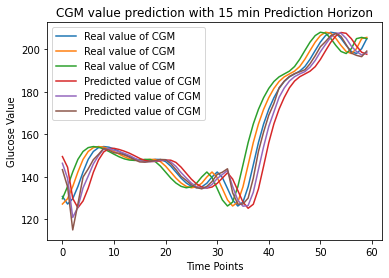

In [ ]:
plt.plot(zf[0:60],label='Real value of CGM')
plt.plot(lf[0:60],label='Predicted value of CGM')
plt.title("CGM value prediction with 15 min Prediction Horizon")
plt.xlabel('Time Points')
plt.ylabel('Glucose Value')
plt.legend()
plt.show()

**MAE**

In [ ]:
from sklearn.metrics import mean_absolute_error
MAE= mean_absolute_error(result['Original CGM at T0'][5:],result['Predicted CGM at T2'][5:])
print(MAE)

2.879709580356348


**RMSE**

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(result['Original CGM at T0'][5:],result['Predicted CGM at T2'][5:]))
print(rmse)

5.370674748241019


**MARD**

In [ ]:
summation = 0
n = len(result['Original CGM at T1'])                                                 
for i in range (5,n):                                      
  difference = abs(result['Original CGM at T0'][i] - result['Predicted CGM at T2'][i])                            
  Devide_Part = difference/result['Original CGM at T0'][i]                       
  summation = summation + Devide_Part                
MARD = summation/n *100                                           
print(MARD)

2.3628400859561127


**For MARD Calculation**

In [ ]:
summation = 0
n = len(origin_cgm_data)                                                 
for i in range (0,n):                                      
  difference = abs(origin_cgm_data[i] - l2[i])                            
  Devide_Part = difference/origin_cgm_data[i]                        
  summation = summation + Devide_Part                
MARD = summation/n *100                                           
print(MARD)

[3.41703107 4.51988241 5.44138377]


In [ ]:
def Average(lst):
    return sum(lst) / len(lst)
lst = [6.95359671, 7.56807031, 8.37607911]
average = Average(lst)
average

7.632582043333334

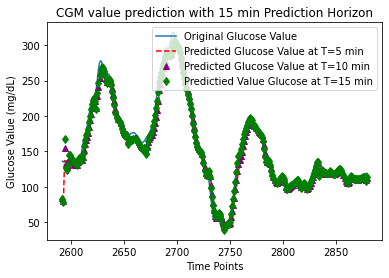

In [ ]:
plt.plot(df['CGM'][2592:],label='Original Glucose Value')
plt.plot(df_final['Predicted CGM'], '--',color="Red", label='Predicted Glucose Value at T=5 min')
plt.plot(df_final['Predicted CGM2'], '^',color="Purple", label='Predicted Glucose Value at T=10 min')
plt.plot(df_final['Predicted CGM3'], 'd',color="Green", label='Predictied Value Glucose at T=15 min')
mpl.rcParams['figure.figsize'] = (22,12)
plt.title("CGM value prediction with 15 min Prediction Horizon")
plt.xlabel('Time Points')
plt.ylabel('Glucose Value (mg/dL)')
plt.legend()
plt.show()

In [ ]:
df_final

,CGM,CHO,Predicted CGM,Predicted CGM2,Predicted CGM3
2592,155.667044,0.0,103.777781,104.381725,105.546423
2593,156.490644,0.0,103.665067,104.899418,106.538355
2594,160.077362,0.0,145.559724,159.522244,170.196399
2595,164.524153,0.0,154.395378,156.803098,157.525658
2596,167.896745,0.0,161.083690,160.286144,158.219014
...,...,...,...,...,...
2875,153.265374,0.0,145.557248,147.289786,148.724248
2876,155.444183,0.0,150.285781,152.894347,154.828023
2877,154.115020,0.0,154.969766,157.098151,158.410219
2878,150.820998,0.0,157.077178,157.245168,156.892315


In [ ]:
xyz=df_final['Predicted CGM'].values

In [ ]:
xyz1=df_final['Predicted CGM2'].values

In [ ]:
xyz2=df_final['Predicted CGM3'].values

In [ ]:
xyz11 = insert(xyz1, 0, 0)

In [ ]:
xyz111=len(xyz11)
new_xyz111=xyz11[:xyz111-1]

In [ ]:
xyz22 = insert(xyz2, 0, 0)
xyz222 = insert(xyz22, 0, 0)
xyz2222=len(xyz222)
new_xyz2222=xyz222[:xyz2222-2]

In [ ]:
xyzv = xyz.reshape((len(xyz), 1,1))
xyz111v = new_xyz111.reshape((len(new_xyz111), 1,1))
xyz2222v = new_xyz2222.reshape((len(new_xyz2222), 1,1))

In [ ]:
avg_data_maker = hstack((xyzv, xyz111v, xyz2222v))

In [ ]:
newarr = avg_data_maker.reshape(288,3*1)

In [ ]:
jk=pd.DataFrame(newarr, columns = ['T0' , 'T1', 'T3'])

In [ ]:
import numpy as np
jk.index = np.arange(2592, len(df) + 0)

In [ ]:
jk['avg'] = jk[['T0', 'T1', 'T3']].mean(axis=1)

In [ ]:
jk

,T0,T1,T3,avg
2592,103.777781,0.000000,0.000000,34.592594
2593,103.665067,104.381725,0.000000,69.348931
2594,145.559724,104.899418,105.546423,118.668522
2595,154.395378,159.522244,106.538355,140.151993
2596,161.083690,156.803098,170.196399,162.694396
...,...,...,...,...
2875,145.557248,143.547929,142.501485,143.868887
2876,150.285781,147.289786,144.195854,147.257141
2877,154.969766,152.894347,148.724248,152.196120
2878,157.077178,157.098151,154.828023,156.334451


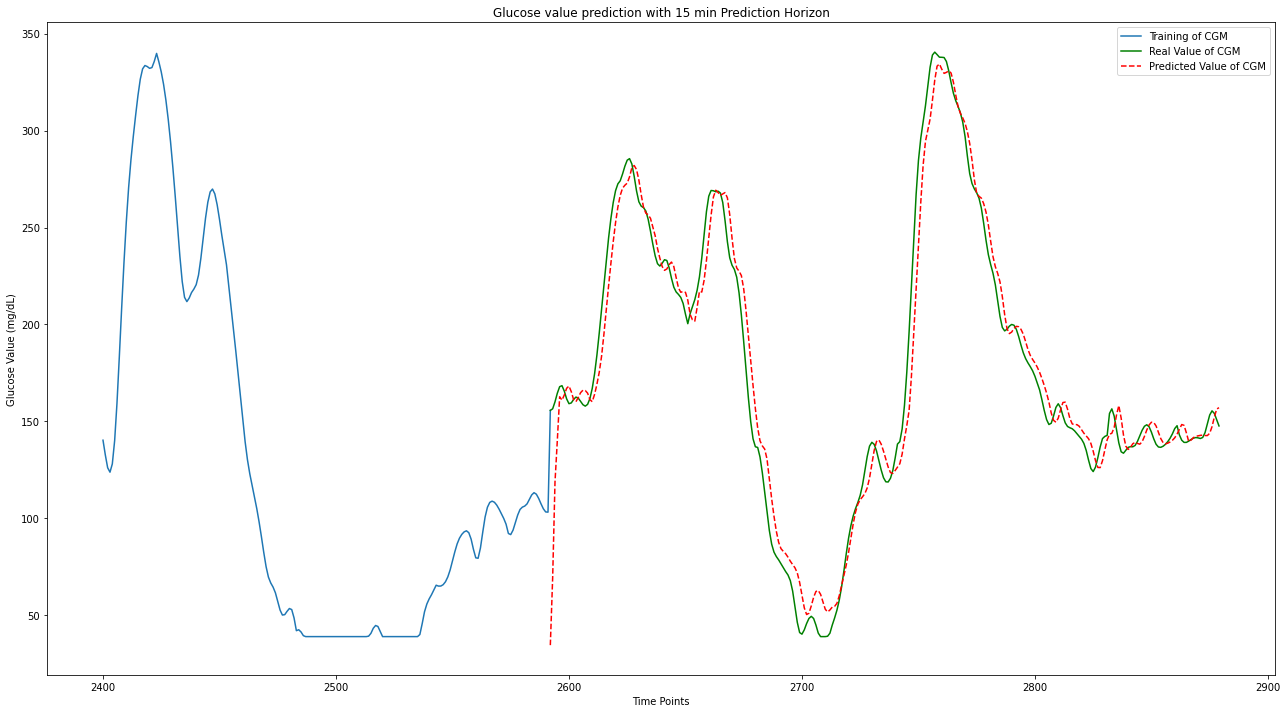

In [ ]:
plt.plot(df['CGM'][2400:2593],label='Training of CGM')
plt.plot(df['CGM'][2592:],color="Green", label='Real Value of CGM')
plt.plot(jk['avg'], '--',color="Red", label='Predicted Value of CGM')
mpl.rcParams['figure.figsize'] = (22,12)
plt.title("Glucose value prediction with 15 min Prediction Horizon")
plt.xlabel('Time Points')
plt.ylabel('Glucose Value (mg/dL)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(df['CGM'].loc[2594:], jk['avg'].loc[2594:]))
print(rmse)

13.476782306103246


In [ ]:
from sklearn.metrics import mean_absolute_error
MAE= mean_absolute_error(df['CGM'].loc[2594:], jk['avg'].loc[2594:])
print(MAE)

10.067247225797892


In [ ]:
origin_cgm_data_RMSE= df['CGM'].loc[2596:]
predicted_cgm_data_RMSE= jk['avg'].loc[2596:]